In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import initializers, regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from numpy import fft
import tensorflow as tf

# FPGheArt - Week 2 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653




# Functions

In [2]:
def plot_res(fit1):
    '''
    Simple function to plot the history of train and validation accuracy
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # summarize history for loss
    ax1.plot(fit1.history['loss'], label = "Train Loss", color = '#648FFF', lw = 2.5)
    ax1.plot(fit1.history['val_loss'], label = "Validation Loss", color = '#FE6100', lw = 2.5)
    ax1.legend()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Model Loss')
    ax1.grid(ls = '--')

    # summarize history for accuracy
    ax2.plot(fit1.history['accuracy'], label = 'Train Accuracy', color =  '#648FFF', lw = 2.5)
    ax2.plot(fit1.history['val_accuracy'], label = 'Validation Accuracy', color = '#FE6100', lw = 2.5)
    ax2.legend()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Model Accuracy')
    ax2.grid(ls = '--')

    plt.show()

In [3]:
def plot_acc(fit, label_fit, colors = ['blue', 'red', 'green']):
    """
    Simple function to compare the learning curve of various model
    """
    fig, ax = plt.subplots(figsize = (10, 7))
    for i in range(len(fit)):
        ax.plot(fit[i].history['accuracy'], label = (label_fit[i] + ' Train Accuracy'), lw = 2.5, ls = '--', color = colors[i])
        ax.plot(fit[i].history['val_accuracy'], label = (label_fit[i] + ' Validation Accuracy'), lw = 2.5, color = colors[i])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Model Accuracy')
    ax.grid(ls = '--')
    ax.legend()
    plt.show()

In [4]:
def plot_conf_mat(c_matrix, ax, title = ''):
    """
    Simple function that plot the confusion matrix
    """
    ax.imshow(c_matrix, cmap = plt.cm.YlGn, alpha = 0.5, vmin = 0, vmax = 1)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    for i in range(3):
        for j in range(3):
            ax.text(x=j, y=i, s=round(c_matrix[i, j],2), ha="center", va="center")
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)
    fig.tight_layout()

In [5]:
def create_CNN(reg, lam, fil, k_size, dense, Poolsize, bias_reg, act_reg):
    """
    This function allow to define a CNN given its parameters
    """
    ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

    model = Sequential()
    if bias_reg == True:        
        model.add(Conv1D(filters = fil[0], kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            bias_regularizer = reg(lam),
                            padding = "same",
                            bias_initializer = ini,
                            activation = "relu",
                            input_shape = input_shape
                            ))
    elif act_reg == True:    
        model.add(Conv1D(filters = fil[0], kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            padding = "same",
                            activity_regularizer = reg(lam),
                            activation = "relu",
                            input_shape = input_shape
                            ))
    else:     
        model.add(Conv1D(filters = fil[0], kernel_size = k_size[0],
                            kernel_regularizer = reg(lam),
                            kernel_initializer=ini,
                            padding = "same",
                            activation = "relu",
                            input_shape = input_shape
                            ))
        
    model.add(AveragePooling1D(Poolsize))
    for i in range(1,len(fil)):
        model.add(Conv1D(filters = fil[i], kernel_size = k_size[i], activation = "relu", padding = "same"))
        model.add(AveragePooling1D(Poolsize))
    model.add(Flatten())
    for i in range(len(dense)):
        model.add(Dense(dense[i],activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(N_categ, activation="softmax"))
    return model

In [6]:
def compile_model(reg = regularizers.l2, lam = 0.001, fil = [5,5], 
                  k_size = [11,7], dense = [10], Poolsize = 5, bias_reg = False, act_reg = False):
    # create the mode
    model=create_CNN(reg, lam, fil, k_size, dense, Poolsize, bias_reg, act_reg)
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer = "adam", metrics = ["accuracy"])
    return model

# Data

In [33]:

x = np.loadtxt("DATA/x_ts_comp_N10000.csv", delimiter =",")
categ_y = np.loadtxt("DATA/y_ts_comp_N10000.csv", delimiter =",")

scaler = StandardScaler()
x =  scaler.fit_transform(x.T).T


In [34]:
y = to_categorical(categ_y)

In [35]:

L = len(x[0])
input_shape = (len(x[0]),1)
N_categ = 3

In [32]:

x = x.reshape(x.shape[0],L,1)


### Augmentation

In [95]:
temp = np.flip(x, axis = 1)

x2 = np.concatenate([x,temp], axis = 0)
y2 = np.concatenate([y,y], axis = 0)

L = len(x2[0])
input_shape = (len(x2[0]),1)
N_categ = 3

x2 = x2.reshape(x2.shape[0],L,1)


## Fourier

In [90]:
x_fourier = fft.rfft(x)
x_fourier[:,-20:-10] = 0
x2 = fft.irfft(x_fourier)
y2 = y

L = len(x2[0])
input_shape = (len(x2[0]),1)
N_categ = 3

x2 = x2.reshape(x2.shape[0],L,1)


In [201]:
ini = initializers.RandomNormal(mean = 0, stddev = 0.05)

model = Sequential()

model.add(Conv1D(filters = 11, kernel_size = 16,
                    kernel_regularizer = regularizers.l2(0.01),
                    kernel_initializer=ini,
                    padding = "same",
                    activation = "relu",
                    input_shape = input_shape
                    ))

model.add(MaxPooling1D(5))

model.add(Flatten())
model.add(Dense(3,activation="relu"))

#model.add(Dropout(0.2))
model.add(Dense(N_categ, activation="softmax"))

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer = "adam", metrics = ["accuracy"])

In [202]:
model.summary()
model.save_weights("competition_weights.h5")


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 60, 11)            187       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 12, 11)            0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 132)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 3)                 399       
_________________________________________________________________
dense_93 (Dense)             (None, 3)                 12        
Total params: 598
Trainable params: 598
Non-trainable params: 0
_________________________________________________________________


0.7822499871253967
0.7792500257492065
0.781000018119812
0.7787500023841858
0.7730000019073486


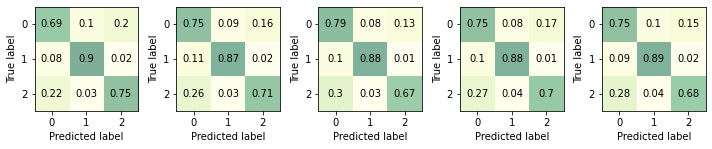

0.77885000705719


In [203]:
acc = []
kfold = KFold(n_splits=5, shuffle=True)
fig, axes = plt.subplots(1,5, figsize = (10,20))
for i, (train, test) in enumerate(kfold.split(x2,y2)):
    model.load_weights("competition_weights.h5")
    hist = model.fit(x2[train], y2[train], batch_size = 250, epochs = 150, 
                 #validation_data = (x_test, y_test), 
                verbose = 0, shuffle = True, use_multiprocessing=True,workers=16)
    scores = model.evaluate(x2[test], y2[test], verbose=0)
    plot_conf_mat(confusion_matrix(np.argmax(y2[test], axis =1),np.argmax(model.predict(x2[test]), axis=1),  normalize = 'true'), axes[i], title = '')
    acc.append(scores[1])
    print(scores[1])
plt.show()
print(np.asarray(acc).mean())



array([ 0.15409884,  0.30289573, -0.26150625, -0.40517221, -0.84130102,
       -0.64632579, -0.09218566,  0.56457301,  1.62667493,  2.11411301,
        2.01662539,  2.24238619,  2.0935893 ,  1.74981718,  0.75441732,
        0.22593182, -0.41030314, -1.30308446, -1.6519875 , -1.16968035,
       -0.80538453, -1.36465558, -1.4621432 , -1.3492628 , -1.19533499,
       -1.48779784, -1.52371433, -0.48726705, -0.83617009, -0.93878863,
       -0.94905049, -0.3846485 , -0.14862586, -0.20506605, -0.35386294,
       -0.15888771, -0.10757844, -0.69763506, -0.70276599, -0.54883817,
       -0.54370724, -0.59501652, -0.23585162, -0.18454235, -0.0254836 ,
       -0.1948042 , -0.32820831,  0.62614414,  1.12384407,  1.08279665,
        1.11871314,  0.75954825,  1.20080798,  1.1854152 ,  0.53891838,
        0.99043997,  1.05201109,  0.32855037,  0.37472871,  0.36959778])